# This python notebook is used to visualise the data collected from the carbon intensity of the UK and the power consumption of the server. #

Import required module

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit

Loading the dataset and conversions

In [3]:
# Load the data
df = pd.read_csv('../data/df_fuel_ckan.csv')

# Convert the DATETIME column to datetime objects
df['DATETIME'] = pd.to_datetime(df['DATETIME'])

Plotting carbon intensity over the full period with the provided time series data (no processing)

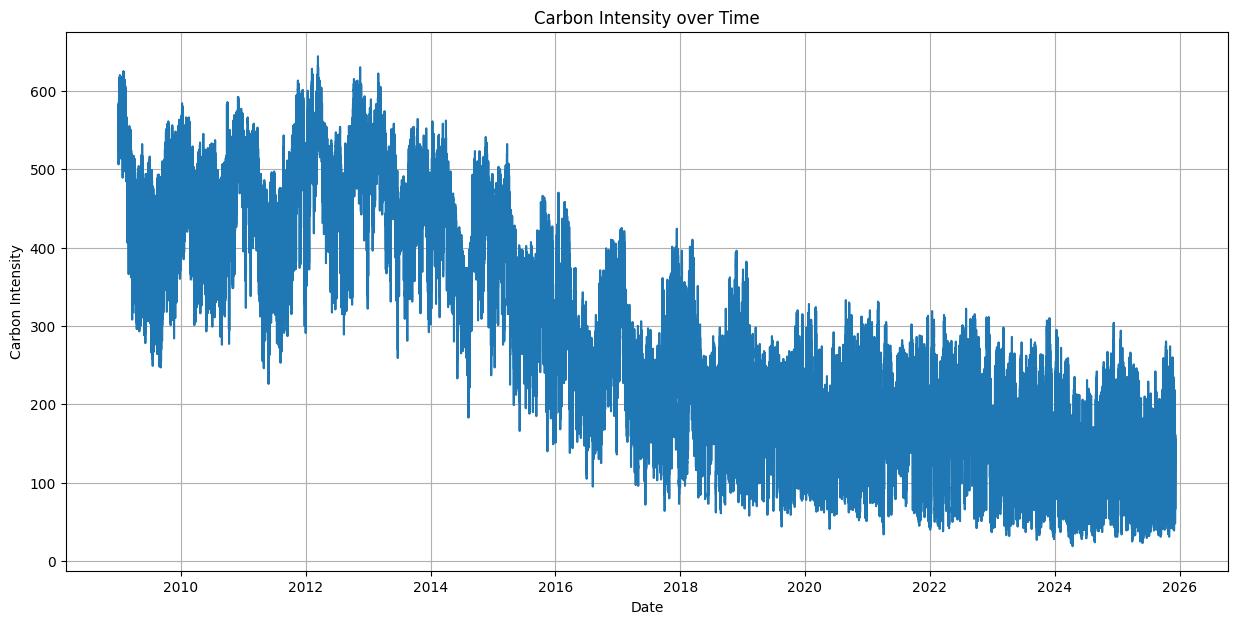

In [4]:
# Plot the data
plt.figure(figsize=(15, 7))
plt.plot(df['DATETIME'], df['CARBON_INTENSITY'])
plt.xlabel('Date')
plt.ylabel('Carbon Intensity')
plt.title('Carbon Intensity over Time')
plt.grid(True)
plt.show()

Resampling the data to monthly frequency and calculate the mean of CARBON_INTENSITY

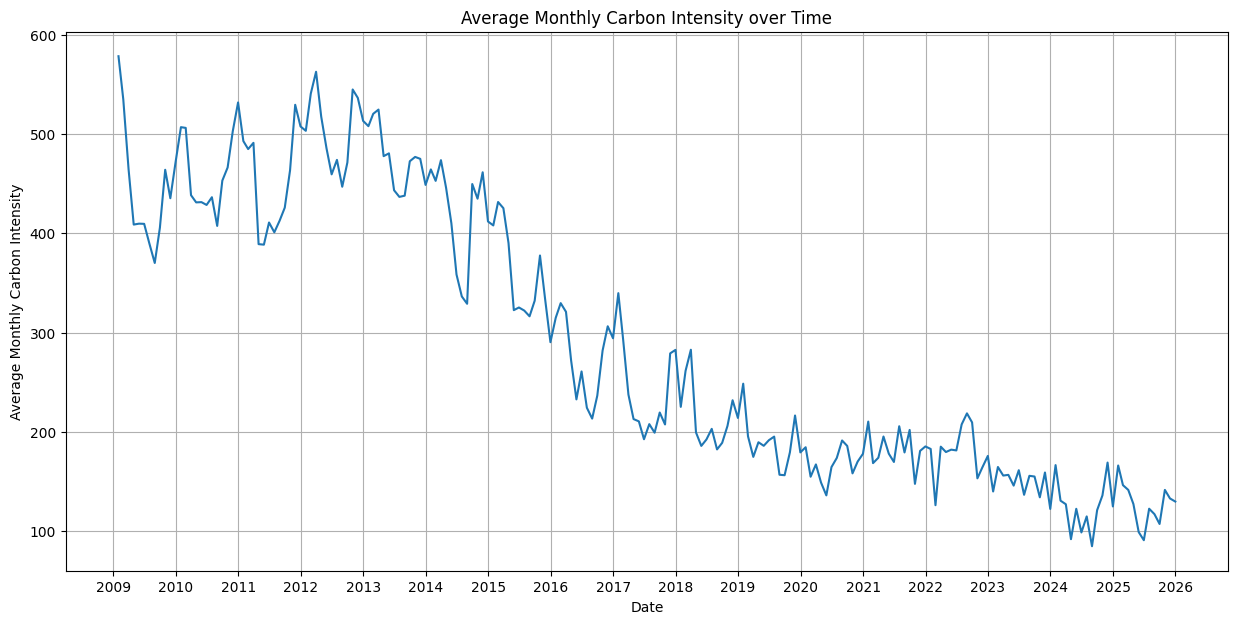

In [5]:
import matplotlib.dates as mdates

# Calculate monthly average carbon intensity
CI_monthly = df.set_index('DATETIME').resample('ME')['CARBON_INTENSITY'].mean()

# Plot the monthly average
plt.figure(figsize=(15, 7))
plt.plot(CI_monthly.index, CI_monthly)
plt.xlabel('Date')
plt.ylabel('Average Monthly Carbon Intensity')
plt.title('Average Monthly Carbon Intensity over Time')

# Set x-axis grid to be exactly 1 year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.grid(True)
plt.show()

We are expecting an annual seasonality

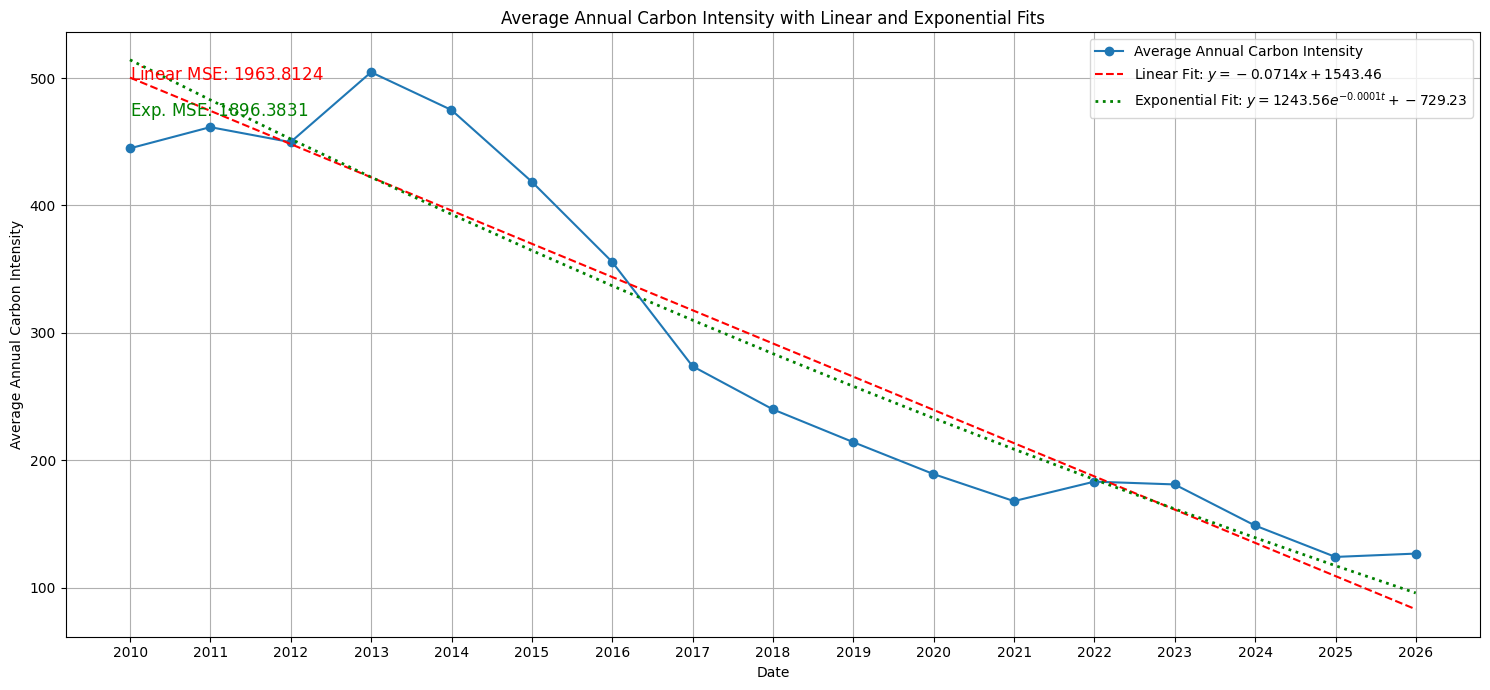

In [6]:
# Calculate annual average carbon intensity
CI_annual = df.set_index('DATETIME').resample('YE')['CARBON_INTENSITY'].mean()

# --- Prepare Data ---
x_dates = CI_annual.index
x_numeric = mdates.date2num(x_dates)
y_values = CI_annual.values

# Normalize x for fitting (start from 0)
x_fit = x_numeric - x_numeric[0]

# --- 1. Linear Regression ---
coefficients_linear = np.polyfit(x_numeric, y_values, 1)
poly_func_linear = np.poly1d(coefficients_linear)
predicted_values_linear = poly_func_linear(x_numeric)
mse_linear = mean_squared_error(y_values, predicted_values_linear)
slope_linear, intercept_linear = coefficients_linear

# --- 2. Exponential Decay Fit ---
def exp_decay(t, a, b, c):
    """Exponential decay function: y = a * exp(-b * t) + c"""
    return a * np.exp(-b * t) + c

# Initial guess for curve_fit
a0 = y_values[0] - y_values[-1]
b0 = 0.0001
c0 = y_values[-1]
p0_exp = [a0, b0, c0]

# Perform curve_fit
try:
    params_exp, covariance = curve_fit(exp_decay, x_fit, y_values, p0=p0_exp, maxfev=5000)
    a_exp, b_exp, c_exp = params_exp
    predicted_values_exp = exp_decay(x_fit, a_exp, b_exp, c_exp)
    mse_exp = mean_squared_error(y_values, predicted_values_exp)
    fit_successful = True
except RuntimeError:
    print("Could not find optimal parameters for exponential fit.")
    fit_successful = False

# --- Plotting ---
plt.figure(figsize=(15, 7))

# Original data plot
plt.plot(x_dates, y_values, marker='o', linestyle='-', label='Average Annual Carbon Intensity')

# Add Linear Regression line
line_label_lin = f'Linear Fit: $y = {slope_linear:.4f}x + {intercept_linear:.2f}$'
plt.plot(x_dates, predicted_values_linear, color='red', linestyle='--', label=line_label_lin)

# Add Exponential Fit line
if fit_successful:
    line_label_exp = f'Exponential Fit: $y = {a_exp:.2f}e^{{-{b_exp:.4f}t}} + {c_exp:.2f}$'
    plt.plot(x_dates, predicted_values_exp, color='green', linestyle=':', linewidth=2, label=line_label_exp)

plt.xlabel('Date')
plt.ylabel('Average Annual Carbon Intensity')
plt.title('Average Annual Carbon Intensity with Linear and Exponential Fits')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add MSE labels on the graph
ax = plt.gca()
y_min, y_max = ax.get_ylim()
x_start = x_dates[0]

# Linear MSE
y_pos_lin = y_max * 0.95
plt.text(x_start, y_pos_lin, f'Linear MSE: ${mse_linear:.4f}$', color='red', fontsize=12,
         horizontalalignment='left', verticalalignment='top')

# Exponential MSE
if fit_successful:
    y_pos_exp = y_max * 0.90
    plt.text(x_start, y_pos_exp, f'Exp. MSE: ${mse_exp:.4f}$', color='green', fontsize=12,
             horizontalalignment='left', verticalalignment='top')

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### It is quite clear that using a linear regression or a exponential decay fit is not a good idea for this data. ###

## Approach using SARIMA model (monthly) ##
Starting off from ARIMA(p, d, q), applying to non-seasonal data
ARIMA stands for autoregressive integrated moving average
where: 
$$Y'_t = \text{Constant} + \sum_{i=1}^p \phi_i Y'_{t-i} + \sum_{j=1}^q \theta_j \epsilon_{t-j} + \epsilon_t$$
Where: <br>
$Y'_t$: The current value of the differenced series. <br>
$\phi_i$: Coefficients of the Autoregressive (AR) terms. <br>
$Y'_{t-i}$: The $i$-th lagged value of the differenced series. <br>
$\theta_j$: Coefficients of the Moving Average (MA) terms.$\epsilon_{t-j}$: The $j$-th lagged forecast error (residual). <br>
$\epsilon_t$: The error term (white noise) at the current time $t$.
SARIMA stands for Seasonal Autoregressive Integrated Moving Average
It basically applies the ARIMA model twice, an additional time after the differencing step to account for seasonality.
$$Y''_t = \text{Constant} + \sum_{i=1}^p \phi_i Y''_{t-i} + \sum_{j=1}^q \theta_j \epsilon_{t-j} + \epsilon_t$$